<a href="https://colab.research.google.com/github/sanggusti/30-days-kaggle/blob/main/jokian_jedoy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning
!pip install medmnist
!pip install wandb

     |████████████████████████████████| 524 kB 7.8 MB/s 
     |████████████████████████████████| 596 kB 53.5 MB/s 
     |████████████████████████████████| 132 kB 69.6 MB/s 
     |████████████████████████████████| 829 kB 45.6 MB/s 
     |████████████████████████████████| 329 kB 71.1 MB/s 
     |████████████████████████████████| 1.1 MB 76.8 MB/s 
     |████████████████████████████████| 271 kB 61.9 MB/s 
     |████████████████████████████████| 192 kB 56.6 MB/s 
     |████████████████████████████████| 160 kB 64.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9fc751837bac11f2cbb4fdee478c4df01fe33544cba2772702357bc115100e74
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [4]:
import os
import sys
from tqdm import trange
from tqdm import tqdm
from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets


import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger


In [17]:
print("Version:", medmnist.__version__)

Version: 2.0.2


In [18]:
flag_to_class = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

## B. Logistic Regression on BreastMNIST

Objectives:

Built 2 models with these criteria:
  - Using the built-in logistic regression functions in scikit-learn, train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3
  - Using PyTorch (see Question 5 of Lab 6), train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3

Get these metrics too

1. Data loading and Inspection
2. Logistic Regression using this [model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
3. Track metrics:
  - M1 Training accuracy
  - M2 Validation accuracy
  - M3 Testing accuracy
4. Performance comparison:
  - summarise each of the three metrics from the two mdoels using one or more bar graphs
  - Describe at least two observations interesting to you


## Tuning Here

Current: *BreastMNIST*

In [ ]:
data_flag = 'breastmnist'
download = True
input_root = 'breastmnist/'

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

In [ ]:
!mkdir breastmnist

In [ ]:
DataClass = flag_to_class[data_flag]

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(root=input_root, split='train', transform=data_transform, download=download)
validation_dataset = DataClass(root=input_root, split='val', transform=data_transform, download=download)
test_dataset = DataClass(root=input_root, split='test', transform=data_transform, download=download)
nonorm_dataset = DataClass(root=input_root, split='train', transform=transforms.ToTensor(), download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: breastmnist/breastmnist.npz
Using downloaded and verified file: breastmnist/breastmnist.npz
Using downloaded and verified file: breastmnist/breastmnist.npz
Using downloaded and verified file: breastmnist/breastmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)
print("===================")
print(nonorm_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: breastmnist/
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: breastmnist/
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'norma

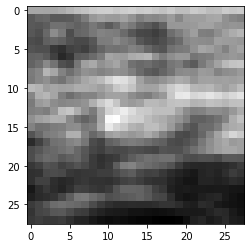

In [ ]:
# visualization

img, target = nonorm_dataset[0]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)

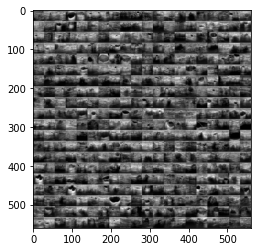

In [ ]:
# montage

def process(n_channels, length=20):
    scale = length * length

    image = np.zeros((scale, 28, 28, 3)) if n_channels == 3 else np.zeros((scale, 28, 28))
    index = [i for i in range(scale)]
    np.random.shuffle(index)
    
    for idx in range(scale):
        img, _ = nonorm_dataset[idx]
        if n_channels == 3:
            img = img.permute(1, 2, 0).numpy()
        else:
            img = img.reshape(28, 28).numpy()
        image[index[idx]] = img

    if n_channels == 1:
        image = image.reshape(scale, 28, 28)
        arr_out = montage(image)
        plt.imshow(arr_out, cmap='gray')
    else:
        image = image.reshape(scale, 28, 28, 3)
        arr_out = montage(image, multichannel=3)
        plt.imshow(arr_out)
    
process(n_channels=n_channels, length=20)

In [ ]:
# here lies the logistic regression model for BreastMNIST
# Logistic Regression using PyTorch
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in)
        return z

model = LogisticRegression(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

## C. Convolutional Neural Network on OctMNIST
1. Data loading and Inspection
2. CNN with metrics:
  - Training accuracy
  - Validation accuracy
  - Testing accuracy
  - Training time

Design two design of CNN with specified architecture
- Design a CNN with two Conv layers and two FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4
- Design a CNN with three Conv layers and three FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4

3. Performance comparison
  - Summarise each of the four metrics from the two models in 2 using one or more bar graphs
  - Describe at least two observations

In [19]:
# Preprocessing, Data Loading and Inspection
data_flag = 'octmnist'
download = True
input_root = 'octmnist/'

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

In [20]:
!mkdir octmnist

In [21]:
DataClass = flag_to_class[data_flag]

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [22]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(root=input_root, split='train', transform=data_transform, download=download)
validation_dataset = DataClass(root=input_root, split='val', transform=data_transform, download=download)
test_dataset = DataClass(root=input_root, split='test', transform=data_transform, download=download)
nonorm_dataset = DataClass(root=input_root, split='train', transform=transforms.ToTensor(), download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: octmnist/octmnist.npz
Using downloaded and verified file: octmnist/octmnist.npz
Using downloaded and verified file: octmnist/octmnist.npz


In [23]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)
print("===================")
print(nonorm_dataset)

Dataset OCTMNIST (octmnist)
    Number of datapoints: 97477
    Root location: octmnist/
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset OCTMNIST (octmnist)
    Number of datapoints: 10832
    Root location: octmnist/
    Split: val
    Task: multi-class

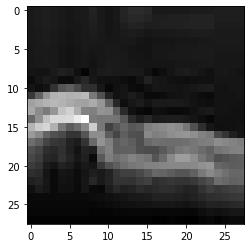

In [24]:
# visualization

img, target = nonorm_dataset[0]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)

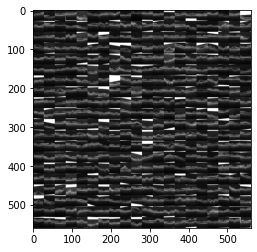

In [25]:
# montage

def process(n_channels, length=20):
    scale = length * length

    image = np.zeros((scale, 28, 28, 3)) if n_channels == 3 else np.zeros((scale, 28, 28))
    index = [i for i in range(scale)]
    np.random.shuffle(index)
    
    for idx in range(scale):
        img, _ = nonorm_dataset[idx]
        if n_channels == 3:
            img = img.permute(1, 2, 0).numpy()
        else:
            img = img.reshape(28, 28).numpy()
        image[index[idx]] = img

    if n_channels == 1:
        image = image.reshape(scale, 28, 28)
        arr_out = montage(image)
        plt.imshow(arr_out, cmap='gray')
    else:
        image = image.reshape(scale, 28, 28, 3)
        arr_out = montage(image, multichannel=3)
        plt.imshow(arr_out)
    
process(n_channels=n_channels, length=20)

In [26]:
# define a simple CNN model

class CNN_A(nn.Module):
    """

    """
    def __init__(self, in_channels, num_classes):
        super(CNN_A, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN_A(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [28]:
wandb_logger = WandbLogger()
trainer = pl.Trainer(
    gpus = min(1, torch.cuda.device_count()),
    max_epochs=NUM_EPOCHS,
    progress_bar_refresh_rate=20,
    logger=wandb_logger
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


ValueError: ignored

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [00:09<00:00,  3.99it/s]


In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                m = nn.Sigmoid()
                outputs = m(outputs)
            else:
                targets = targets.squeeze().long()
                m = nn.Softmax(dim=1)
                outputs = m(outputs)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
    
        print('%s  acc: %.3f  auc:%.3f' % (split, acc, auc))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  acc: 0.980  auc:0.998
test  acc: 0.825  auc:0.955


D. Unsupervised learning on Fashion-MNIST

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns
from torch.utils.data import DataLoader

In [15]:
def get_fashion_mnist_test_loaders(batch_size=128):
    """Fashion MNIST dataloader with (32, 32) sized images."""
    # Resize images so they are a power of 2
    all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    # Get test data
    test_data = datasets.FashionMNIST('../fashion_data', train=False,
                                      transform=all_transforms, download=True)
    # Create dataloaders
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return test_loader

In [16]:
get_fashion_mnist_test_loaders()

In [ ]:
class MNISTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def prepare_data(self):
        # download MNIST data only once
        MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
        MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())

    def forward(self, x):
        # called with self(x)
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    def train_dataloader(self):
        # REQUIRED
        return DataLoader(
            MNIST(os.getcwd(), train=True, download=False, transform=transforms.ToTensor()), batch_size=32
        )

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(
            MNIST(os.getcwd(), train=True, download=False, transform=transforms.ToTensor()), batch_size=32
        )

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(
            MNIST(os.getcwd(), train=True, download=False, transform=transforms.ToTensor()), batch_size=32
        )

In [ ]:
if __name__ == "__main__":
    wandb_logger = WandbLogger()
    mnist_model = MNISTModel()
    trainer = pl.Trainer(gpus=0, max_epochs=2, logger=wandb_logger)
    trainer.fit(mnist_model)
    trainer.test(mnist_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.332375407218933}
--------------------------------------------------------------------------------
